## Predict Future Sales


### Problem Statement
With daily historical data, our main goal is to create and optimize a model that makes a forecast on the total number of items for **each** item id sold in **every** shop in the test set (month of November 2015) as their prices fluctuate across time. 

In [75]:
# saving all required libraries under requirements.txt
! pip freeze > requirements.txt

In [2]:
# import necessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,LSTM, TimeDistributed, Flatten, MaxPooling1D,Conv1D,Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet,HuberRegressor,PassiveAggressiveRegressor,SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings("ignore")
%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [77]:
# with open('requirements.txt') as f:
#     print(f.read())

### Reading data

In [4]:
# Load all data
train = pd.read_csv('../data/sales_train.csv')
test = pd.read_csv('../data/test.csv')
items = pd.read_csv('../data/items.csv')
items_cat = pd.read_csv('../data/item_categories.csv')
shops = pd.read_csv('../data/shops.csv')

## Exploratory Data Analysis
Quick EDA and data cleaning, mainly to remove anomalies that might skew our data and to establish a few assumptions! 

### Data visualiztion

In [5]:
# first 5 rows of train data
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,1709.050,1.000
4,15.01.2013,0,25,2555,1099.000,1.000


In [6]:
# first 5 rows of test data
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
# first 5 rows of shop name and id
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
# item name, id and category-id
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
# item category and category id, to mape to item names in items
items_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
# statistical summary of each feature, assuming negative means more items are returned than sold
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


In [11]:
# checking for missing values
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [12]:
# check for duplicates
train[train.duplicated(keep = False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.000,1.000
76962,05.01.2013,0,54,20130,149.000,1.000
1435365,23.02.2014,13,50,3423,999.000,1.000
1435367,23.02.2014,13,50,3423,999.000,1.000
1496765,23.03.2014,14,21,3423,999.000,1.000
1496766,23.03.2014,14,21,3423,999.000,1.000
1671872,01.05.2014,16,50,3423,999.000,1.000
1671873,01.05.2014,16,50,3423,999.000,1.000
1866322,12.07.2014,18,25,3423,999.000,1.000
1866340,12.07.2014,18,25,3423,999.000,1.000


In [13]:
# drop duplicates, keep one copy
train.drop_duplicates(keep = 'first',inplace = True)

In [14]:
# Changing the date column to datetime format and date as index
train.date = pd.to_datetime(train.date, format = '%d.%m.%Y' )
# train = train.set_index('date')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000,1.000
1,2013-01-03,0,25,2552,899.000,1.000
2,2013-01-05,0,25,2552,899.000,-1.000
3,2013-01-06,0,25,2554,1709.050,1.000
4,2013-01-15,0,25,2555,1099.000,1.000


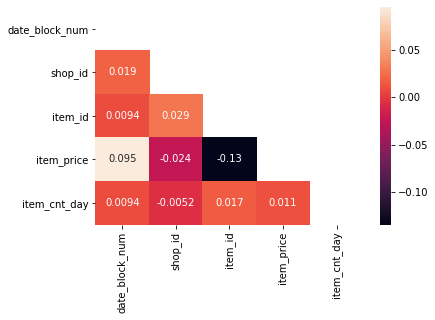

In [15]:
# Looking at the correlation between features
mask = np.triu(np.ones_like(train.corr(),dtype = bool))
f,ax = plt.subplots()
sns.heatmap(train.corr(),mask = mask,annot = True);

In [16]:
# setting date as index
train_1 = train.copy()
train_1 = train_1.set_index('date').sort_index()
train_1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-01,0,18,16182,1619.000,1.000
2013-01-01,0,54,12355,399.000,1.000
2013-01-01,0,54,16877,149.000,1.000
2013-01-01,0,27,15435,499.000,1.000
2013-01-01,0,54,19678,149.000,1.000
...,...,...,...,...,...
2015-10-31,33,50,8918,28.000,1.000
2015-10-31,33,6,8116,1699.000,1.000
2015-10-31,33,37,2423,499.000,3.000


Text(0.5, 0, 'Year - Month')

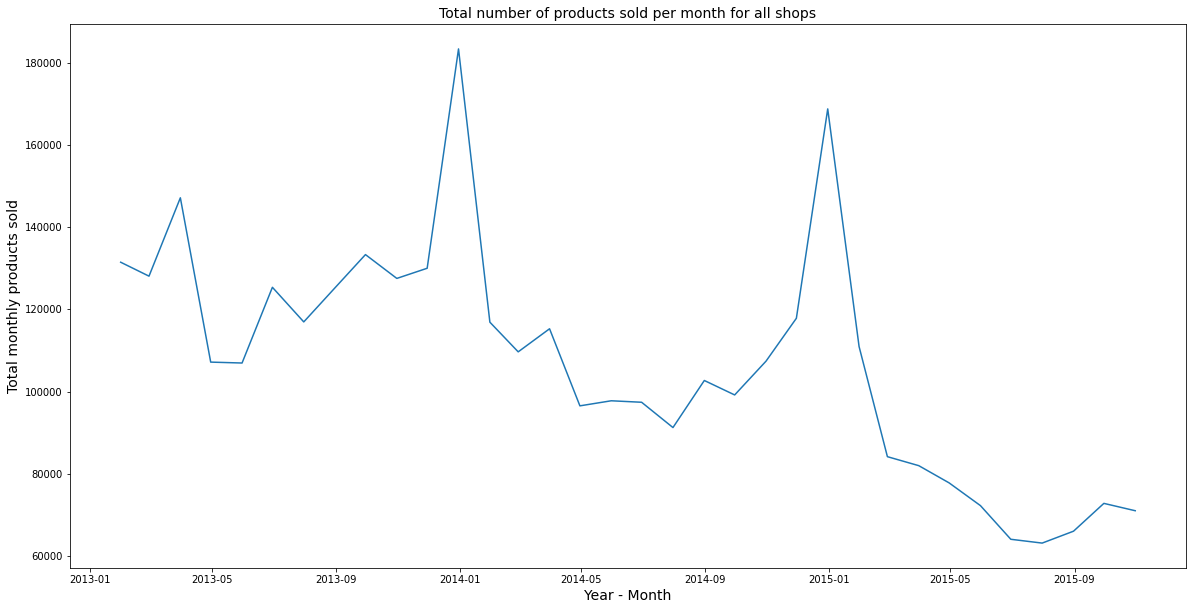

In [17]:
# looking at total number of products sold throughout the months
# sales is the highest in Jan of every month
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(train_1.resample('M').agg({'item_price':'mean','item_cnt_day':'sum'})['item_cnt_day'])
ax.set_title('Total number of products sold per month for all shops',fontsize = 14)
ax.set_ylabel('Total monthly products sold',fontsize = 14)
ax.set_xlabel('Year - Month',fontsize = 14)

### `item_cnt_day`

<AxesSubplot:xlabel='item_cnt_day'>

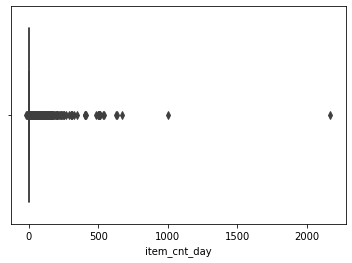

In [18]:
# Looking at the distribution of target variable
sns.boxplot(train.item_cnt_day)

In [19]:
train[train.item_cnt_day > 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.909,2169.000


<AxesSubplot:xlabel='item_cnt_day'>

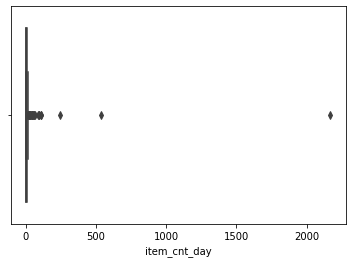

In [20]:
# based on the distribution of past item_cnt_day of the same item, seems like its an anomaly 
sns.boxplot(train[train.item_id == 11373]["item_cnt_day"])

In [21]:
# Drop the anomaly
train.drop(2909818,inplace = True)

### `item_price`

<AxesSubplot:xlabel='item_price'>

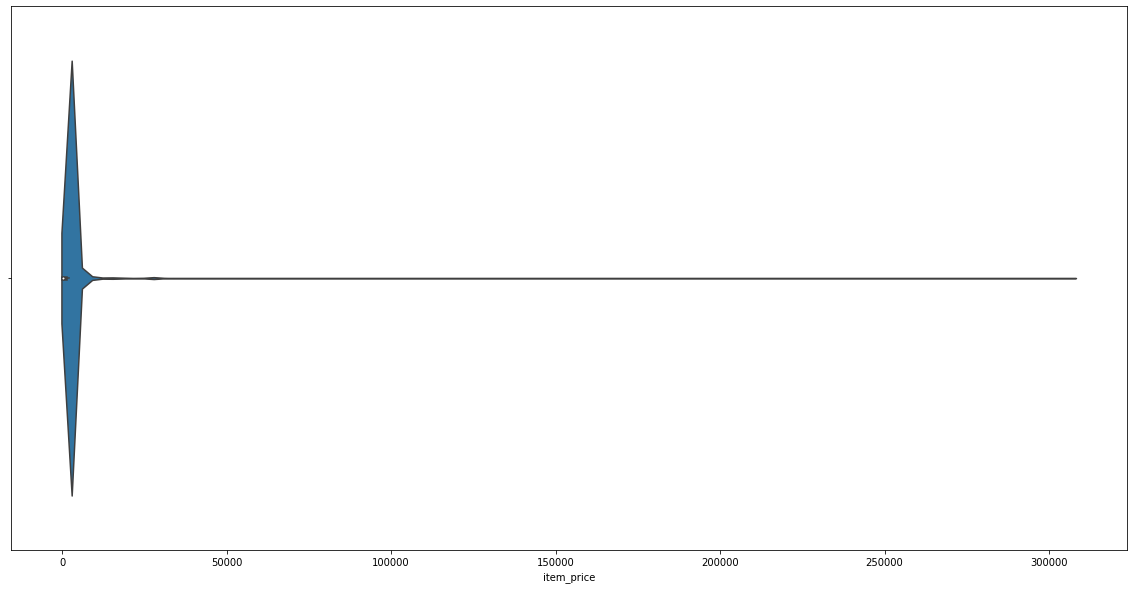

In [22]:
fig,ax = plt.subplots(figsize = (20,10))
sns.violinplot(train.item_price)

In [23]:
# There is an extreme outlier with price > 300000
train[train.item_price > 250000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.000,1.000


In [24]:
# Only 1 item with that price, might be an outlier
train[train.item_id == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.000,1.000


In [25]:
# Drop the outlier
train.drop(1163158,inplace = True)

### Pre-target variable: `item_cnt_day`
target variable is the monthly value: `item_cnt_month`

In [26]:
# extracting year and month
train_1['year_month'] = train_1.index.strftime('%Y-%m')

In [27]:
# group according to shop_id and item_id
df = pd.pivot_table(train_1, index = ['shop_id','item_id'], 
                              columns = 'year_month',
                              values = 'item_cnt_day',
                              aggfunc = np.sum,
                              fill_value = 0)
df = df.reset_index().rename_axis(None,axis = 1)
df

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424121,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424122,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


In [30]:
# to filter out those item counts that we want to predict afterwards
df_test = test.merge(df, on = ['shop_id','item_id'],how = 'left').fillna(0).drop(columns = 'ID')

# drop redundant columns for df_test
df_test = df_test.drop(columns = ['shop_id','item_id'])
df_test.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.000,0.000,0.000,0.000,1.000,1.000,1.000,3.000,1.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,3.000,2.000,0.000,1.000,3.000,1.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [31]:
# df_test_train: Training set where we use all dates except the latest one to train model
# df_test_val: Test set where we use latest date to validate model
df_test_train = df_test.iloc[:,:-1]
df_test_val = df_test.iloc[:,-1]

In [32]:
print(f'validation set: {df_test_val.shape}')
print(f'train set: {df_test_train.shape}')

validation set: (214200,)
train set: (214200, 33)


### Data Modeling 
Using **2015-10** as our target feature and earlier time periods as our predictor features

In [33]:
# train test split df: X = all columns except last one, y = last column
X = df_test_train
y = df_test_val
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle = False,test_size = 0.2, random_state = 42)

In [34]:
# looking at rows, columns for train and validation set
print(f'train: {X.shape}')
print(f'test: {y.shape}')
print(f'val train: {X_test.shape}')
print(f'val test: {y_test.shape}')

train: (214200, 33)
test: (214200,)
val train: (42840, 33)
val test: (42840,)


### StandardScaler
Normalize scales of features to improve accuracy of predictions especially if our variables are on different scales/magnitudes. This is because this would affect the performances of models that specifically rely on distance metrics(k-NN, PCA) as well as to speed up gradient descent convergence for deep neural networks during backpropagation. Mainly to ensure that every feature contributes equally to the models! 

In [35]:
# scale data
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [36]:
def get_models(models=dict()):
# linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
   
    return models

def get_models_nl(models=dict()):
# non-linear models
    models['svr'] = SVR()
# ensemble models
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    return models

def pipeline(model):
    pipe = Pipeline([(model, model_dict[model])])
    return pipe

def params(model):
    

    if model == 'lasso':
        return {"alpha":[0.01,0.1,1,2,5,10],
               }
    
    
    elif model == 'ridge':
        return {
            "alpha":[0.01,0.1,1,2,5,10],
            }
    
    elif model == 'en':
        return {
            'alpha':[0.01,0.1,1,10],
            'l1_ratio':[0.2,0.3,0.4,0.5,0.6]
            }
    elif model == 'knn':
        return {
            'n_neighbors':[4,5,6,7]}

    elif model == 'dt':
        return {
            'max_depth':[3,4,5],
            'min_samples_split':[2,3,4],
            'min_samples_leaf':[2,3,4]
        }
    elif model == 'bag':
        return {
            'max_features':[100, 150]
        }
        
    elif model == 'rf':
        return {
            'n_estimators':[100,150],
            'max_depth':[4],
            'min_samples_leaf':[2,3,4]
        }
    elif model == 'et':
        return {
            'n_estimators':[50,100,150],
            'max_depth':[5],
            'min_samples_leaf':[2,3],
        }
    elif model == 'abc':
        return {
            'n_estimators':[50, 100,150],
            'learning_rate':[0.3,0.6,1]
        }
    elif model == 'gbc':
        return {
            'learning_rate':[0.2],
            'max_depth':[5],
            'min_samples_split':[2,5]
            
        }
    elif model == 'xgb':
        return {
            'eval_metric' : ['auc'],
            'subsample' : [0.8], 
            'colsample_bytree' : [0.5], 
            'learning_rate' : [0.1],
            'max_depth' : [5], 
            'scale_pos_weight': [5], 
            'n_estimators' : [100,200],
            'reg_alpha' : [0, 0.05],
            'reg_lambda' : [2,3],
            'gamma' : [0.01]
                             
        }
    elif model == 'svr':
        return {
            'kernel': ['rbf', 'linear','poly'], 
            'C': [1,20,50,100],
            'gamma':['scale','auto'],
            'epsilon':[0.1,1,10]
        }
    elif model == 'ada':
        return {
            'n_estimators':[50,100,150],
            'learning_rate':[0.01,0.1,1],
            
        }
    elif model == 'bag':
        return {
            'n_estimators':[20,50,100,150],
            'max_features':[5,10,20],
            'max_samples':[0.1,0.2,0.3,0.5,0.7],
            'bootstrap':[True]
            
        }
    elif model == 'rf':
        return {
             'bootstrap': [True],
             'max_depth': [5,10,20],
             'max_features': ["auto", "sqrt", "log2"],
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,5,8,10],
             'n_estimators': [50,200,300,400],
             'random_state': 42,
             }
    elif model == 'et':
        return {
             'bootstrap': [True],
             'max_depth': [5,10,20],
             'max_features': ["auto", "sqrt", "log2"],
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,5,8,10],
             'n_estimators': [50,200,300,400],
             'random_state': 42,
        }
            
    elif model == 'gbm':
        return {
            'learning_rate' : [0.1,0.3,0.6,1], 
            'min_samples_split':[500,1000,2000,3000,5000],
            'min_samples_leaf': [50,200,400,1000],
            'max_depth' : [8,10,20,30]
        }

In [37]:
def evaluate_models(models, X_train_ss,y_train,X_test_ss,y_test):
    for name, model in models.items():
    # fit models
        model_fit = model.fit(X_train_ss,y_train)
        # make predictions
        train_preds = model_fit.predict(X_train_ss)
        test_preds = model_fit.predict(X_test_ss)
        # evaluate forecast
        train_mse = mean_squared_error(y_train,train_preds)
        test_mse = mean_squared_error(y_test,test_preds)
        print(f'{name}:')
        print(f'----')
        print(f'Train MAE: {round(train_mse,2)}')
        print(f'Test MAE: {round(test_mse,2)}')
        print(f'\n')
    



In [38]:
# grid search with gridsearchcv
def grid_search(model,models,X_train = X_train_ss,y_train = y_train,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    model = models[model]
    gs = GridSearchCV(model,param_grid = pipe_params,cv = 5,scoring = 'neg_mean_squared_error', verbose=True, n_jobs=8)
    gs.fit(X_train_ss,y_train)
    train_score = gs.score(X_train_ss,y_train)
    test_score = gs.score(X_test_ss,y_test)
    
    print(f'Results from: {model}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'Mean MSE: {round(gs.best_score_,4)}')
    print(f'Train Score: {round(train_score,4)}')
    print(f'Test Score: {round(test_score,4)}')
    print(' ')

In [39]:
# grid search with randomizedsearchcv
def grid_search_rs(model,models,X_train = X_train_ss,y_train = y_train,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    model = models[model]
    gs = RandomizedSearchCV(model,param_distributions = pipe_params,cv = 5,scoring = 'neg_mean_squared_error', verbose=True, n_jobs=8)
    gs.fit(X_train_ss,y_train)
    train_score = gs.score(X_train_ss,y_train)
    test_score = gs.score(X_test_ss,y_test)
    
    print(f'Results from: {model}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'Mean MSE: {round(gs.best_score_,4)}')
    print(f'Train Score: {round(train_score,4)}')
    print(f'Test Score: {round(test_score,4)}')
    print(' ')

### Linear models

In [40]:
models = get_models()
evaluate_models(models,X_train_ss,y_train,X_test_ss,y_test)

lr:
----
Train MAE: 17.96
Test MAE: 3.32


lasso:
----
Train MAE: 24.46
Test MAE: 1.01


ridge:
----
Train MAE: 17.96
Test MAE: 3.32


en:
----
Train MAE: 24.51
Test MAE: 0.88


huber:
----
Train MAE: 32.23
Test MAE: 0.83


pa:
----
Train MAE: 35.71
Test MAE: 1.53




In [98]:
# best params of lasso
%time grid_search('lasso',models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Results from: Lasso()
-----------------------------------
Best Hyperparameters: {'alpha': 0.1}
Mean MSE: -31.5447
Train Score: -19.0354
Test Score: -1.9192
 
Wall time: 8.75 s


In [99]:
%%time
grid_search_rs('lasso',models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Results from: Lasso()
-----------------------------------
Best Hyperparameters: {'alpha': 0.1}
Mean MSE: -31.5447
Train Score: -19.0354
Test Score: -1.9192
 
Wall time: 6.63 s


In [100]:
# best params of en:
%time grid_search_rs('en',models)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Results from: ElasticNet()
-----------------------------------
Best Hyperparameters: {'l1_ratio': 0.2, 'alpha': 0.1}
Mean MSE: -31.1294
Train Score: -18.9416
Test Score: -1.9402
 
Wall time: 15.7 s


In [101]:
# best params of en:
%time grid_search('en',models)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Results from: ElasticNet()
-----------------------------------
Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.2}
Mean MSE: -31.1294
Train Score: -18.9416
Test Score: -1.9402
 
Wall time: 36.9 s


### LSTM
An extension of RNN that overcomes the vanishing gradient problem and to learn long term dependencies in sequence prediction problems using the memory cells present in the hidden states!

In [41]:
X_train_ss.shape

(171360, 33)

In [42]:
# reshape [samples,timesteps] into expected shape [samples,timesteps,n_features]
# samples = number of records ,timestep = how far back are we looking? , n_features = no. of variables, 1 as we are only using cnt to predict next month's cnt
X_train_ss_rs = X_train_ss.reshape((X_train_ss.shape[0],X_train_ss.shape[1],1))
X_test_ss_rs = X_test_ss.reshape((X_test_ss.shape[0],X_test_ss.shape[1],1))
ss1 = StandardScaler()
ss1.fit(y_train.values.reshape(y_train.shape[0],1))
y_train_ss = ss1.transform(y_train.values.reshape(y_train.shape[0],1))

Epoch 1/30
4/4 - 12s - loss: 0.0921
Epoch 2/30
4/4 - 10s - loss: 0.0787
Epoch 3/30
4/4 - 10s - loss: 0.0685
Epoch 4/30
4/4 - 10s - loss: 0.0623
Epoch 5/30
4/4 - 10s - loss: 0.0644
Epoch 6/30
4/4 - 10s - loss: 0.0635
Epoch 7/30
4/4 - 10s - loss: 0.0656
Epoch 8/30
4/4 - 10s - loss: 0.0625
Epoch 9/30
4/4 - 10s - loss: 0.0619
Epoch 10/30
4/4 - 10s - loss: 0.0619
Epoch 11/30
4/4 - 11s - loss: 0.0584
Epoch 12/30
4/4 - 11s - loss: 0.0573
Epoch 13/30
4/4 - 14s - loss: 0.0550
Epoch 14/30
4/4 - 13s - loss: 0.0545
Epoch 15/30
4/4 - 14s - loss: 0.0533
Epoch 16/30
4/4 - 15s - loss: 0.0525
Epoch 17/30
4/4 - 11s - loss: 0.0522
Epoch 18/30
4/4 - 11s - loss: 0.0514
Epoch 19/30
4/4 - 11s - loss: 0.0518
Epoch 20/30
4/4 - 10s - loss: 0.0503
Epoch 21/30
4/4 - 10s - loss: 0.0495
Epoch 22/30
4/4 - 10s - loss: 0.0492
Epoch 23/30
4/4 - 10s - loss: 0.0487
Epoch 24/30
4/4 - 10s - loss: 0.0495
Epoch 25/30
4/4 - 10s - loss: 0.0489
Epoch 26/30
4/4 - 10s - loss: 0.0480
Epoch 27/30
4/4 - 10s - loss: 0.0496
Epoch 28/3

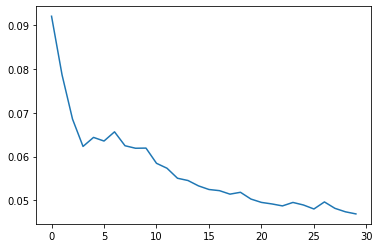

In [104]:
%%time
model = Sequential()
model.add(LSTM(50, input_shape = (X_train_ss_rs.shape[1],X_train_ss_rs.shape[2]),activation = 'relu'))
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss = 'mae',optimizer = 'adam')
history = model.fit(X_train_ss_rs,y_train_ss,epochs = 30, batch_size = 50000, verbose = 2,shuffle = False)
plt.plot(history.history['loss'],label = 'loss')

Epoch 1/50
2/2 - 12s - loss: 0.0938
Epoch 2/50
2/2 - 10s - loss: 0.0853
Epoch 3/50
2/2 - 10s - loss: 0.0763
Epoch 4/50
2/2 - 10s - loss: 0.0663
Epoch 5/50
2/2 - 10s - loss: 0.0662
Epoch 6/50
2/2 - 10s - loss: 0.0661
Epoch 7/50
2/2 - 10s - loss: 0.0651
Epoch 8/50
2/2 - 10s - loss: 0.0634
Epoch 9/50
2/2 - 10s - loss: 0.0621
Epoch 10/50
2/2 - 10s - loss: 0.0608
Epoch 11/50
2/2 - 10s - loss: 0.0590
Epoch 12/50
2/2 - 10s - loss: 0.0582
Epoch 13/50
2/2 - 10s - loss: 0.0579
Epoch 14/50
2/2 - 10s - loss: 0.0567
Epoch 15/50
2/2 - 10s - loss: 0.0562
Epoch 16/50
2/2 - 10s - loss: 0.0553
Epoch 17/50
2/2 - 10s - loss: 0.0553
Epoch 18/50
2/2 - 10s - loss: 0.0548
Epoch 19/50
2/2 - 10s - loss: 0.0541
Epoch 20/50
2/2 - 10s - loss: 0.0537
Epoch 21/50
2/2 - 10s - loss: 0.0533
Epoch 22/50
2/2 - 10s - loss: 0.0524
Epoch 23/50
2/2 - 10s - loss: 0.0525
Epoch 24/50
2/2 - 10s - loss: 0.0521
Epoch 25/50
2/2 - 10s - loss: 0.0516
Epoch 26/50
2/2 - 10s - loss: 0.0514
Epoch 27/50
2/2 - 10s - loss: 0.0512
Epoch 28/5

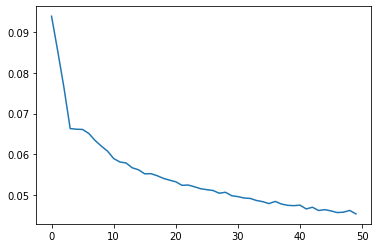

In [105]:
%%time
model_1 = Sequential()
# [samples,timesteps,features]
model_1.add(LSTM(50, input_shape = (X_train_ss_rs.shape[1],X_train_ss_rs.shape[2]),activation = 'relu'))
model_1.add(Dense(16,activation = 'relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(1))
model_1.compile(loss = 'mae',optimizer = 'adam')
history_1 = model_1.fit(X_train_ss_rs,y_train_ss,epochs = 50, batch_size = 100000, verbose = 2,shuffle = False)
plt.plot(history_1.history['loss'],label = 'loss')

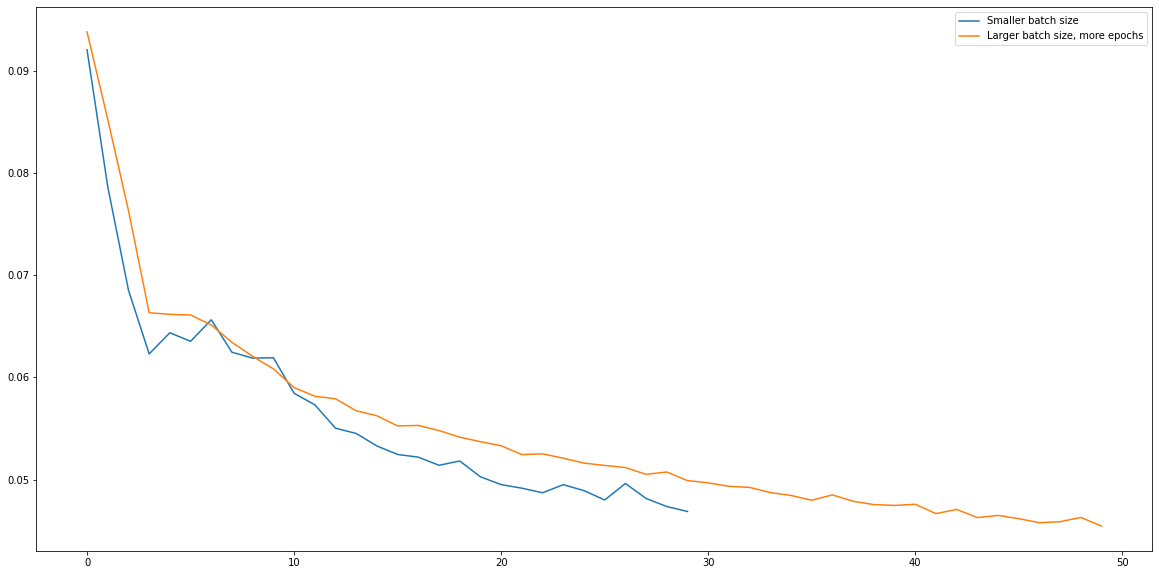

In [110]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(history.history['loss'],label = 'Smaller batch size')
ax.plot(history_1.history['loss'],label = 'Larger batch size, more epochs')
# ax.plot(history_2.history['loss'],label = 'Larger batch size, more epochs, no relu')
plt.legend()

In [50]:
# function to evaluate performance of models
def mae_train_test(model,model_name, X_train,y_train,X_test,y_test,ss1):
    trainpreds = ss1.inverse_transform(model.predict(X_train)).reshape((y_train.shape[0],))
    testpreds = ss1.inverse_transform(model.predict(X_test)).reshape((y_test.shape[0],))
    print(f'Model: {model_name}')
    print('----')
    print(f'Train MAE: {mean_squared_error(y_train,trainpreds)}')
    print(f'Test MAE: {mean_squared_error(y_test,testpreds)}')
    print('\n')
    

In [112]:
mae_train_test(model,"LSTM - Smaller Batch Size", X_train_ss_rs,y_train,X_test_ss_rs,y_test,ss1)
mae_train_test(model_1,"LSTM - Larger Batch Size, more epochs", X_train_ss_rs,y_train,X_test_ss_rs,y_test,ss1)
# mae_train_test(model_2,"LSTM -Larger Batch Size, more epochs, no relu", X_train_ss_rs,y_train,X_test_ss_rs,y_test,ss1)

Model: LSTM - Smaller Batch Size
----
Train MAE: 33.793531372637474
Test MAE: 0.8218399035882286


Model: LSTM - Larger Batch Size, more epochs
----
Train MAE: 28.381191756903092
Test MAE: 0.7468863822650611




### CNN-LSTM
CNN: For additional feature engineering, LSTM: to overcome vanishing gradient problem and to learn long-term dependencies. 

In [45]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (171360, 33)
Shape of X_test: (42840, 33)


In [46]:
# required input shape: [samples, subsequences, timesteps, features]
# number of samples: 
subseq = 1
ts = 33
ss_cnn = StandardScaler()
ss_cnn.fit(X_train)
X_train_sub = ss_cnn.transform(X_train).reshape((X_train.shape[0],subseq,ts,1))
X_test_sub = ss_cnn.transform(X_test).reshape((X_test.shape[0],subseq,ts,1))
print(f'Shape of X_train_sub: {X_train_sub.shape}')
print(f'Shape of X_test_sub: {X_test_sub.shape}')

Shape of X_train_sub: (171360, 1, 33, 1)
Shape of X_test_sub: (42840, 1, 33, 1)


In [115]:
%%time 
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, input_shape = (None,X_train_sub.shape[2],X_train_sub.shape[3]),activation = 'relu')))
cnn_lstm.add(TimeDistributed(Dropout(0.4)))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size = 1)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(50, activation = 'relu',return_sequences = True))
cnn_lstm.add(Dense(16,activation = 'relu'))
cnn_lstm.add(Dropout(0.4))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss= 'mae',optimizer = 'adam')
cnn_lstm_history = cnn_lstm.fit(X_train_sub,y_train_ss, epochs = 50, batch_size = 100000, verbose = 2,shuffle = False)


Epoch 1/50
2/2 - 20s - loss: 0.0852
Epoch 2/50
2/2 - 7s - loss: 0.0659
Epoch 3/50
2/2 - 7s - loss: 0.0663
Epoch 4/50
2/2 - 7s - loss: 0.0614
Epoch 5/50
2/2 - 7s - loss: 0.0600
Epoch 6/50
2/2 - 7s - loss: 0.0600
Epoch 7/50
2/2 - 7s - loss: 0.0576
Epoch 8/50
2/2 - 7s - loss: 0.0577
Epoch 9/50
2/2 - 7s - loss: 0.0571
Epoch 10/50
2/2 - 7s - loss: 0.0559
Epoch 11/50
2/2 - 7s - loss: 0.0554
Epoch 12/50
2/2 - 8s - loss: 0.0557
Epoch 13/50
2/2 - 7s - loss: 0.0549
Epoch 14/50
2/2 - 8s - loss: 0.0545
Epoch 15/50
2/2 - 7s - loss: 0.0546
Epoch 16/50
2/2 - 7s - loss: 0.0544
Epoch 17/50
2/2 - 7s - loss: 0.0538
Epoch 18/50
2/2 - 7s - loss: 0.0535
Epoch 19/50
2/2 - 7s - loss: 0.0531
Epoch 20/50
2/2 - 8s - loss: 0.0527
Epoch 21/50
2/2 - 7s - loss: 0.0527
Epoch 22/50
2/2 - 7s - loss: 0.0522
Epoch 23/50
2/2 - 7s - loss: 0.0520
Epoch 24/50
2/2 - 7s - loss: 0.0518
Epoch 25/50
2/2 - 7s - loss: 0.0517
Epoch 26/50
2/2 - 7s - loss: 0.0511
Epoch 27/50
2/2 - 7s - loss: 0.0514
Epoch 28/50
2/2 - 7s - loss: 0.0507


In [89]:
# cnn_lstm.reset_states()

In [48]:
%%time
cnn_lstm_1 = Sequential()
cnn_lstm_1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 11, input_shape = (None,1,X_train_sub.shape[2],X_train_sub.shape[3]),activation = 'relu')))
cnn_lstm_1.add(TimeDistributed(Dropout(0.4)))
cnn_lstm_1.add(TimeDistributed(MaxPooling1D(pool_size = 1)))
cnn_lstm_1.add(TimeDistributed(Flatten()))
cnn_lstm_1.add(LSTM(50, activation = 'relu'))
cnn_lstm_1.add(Dense(16))
cnn_lstm_1.add((Dropout(0.4)))
cnn_lstm_1.add(Dense(1))
cnn_lstm_1.compile(loss= 'mae',optimizer = 'adam')
cnn_lstm_1_history = cnn_lstm_1.fit(X_train_sub,y_train_ss, epochs = 30, batch_size = 100000, verbose = 2,shuffle = False)


Epoch 1/30
2/2 - 32s - loss: 0.0886
Epoch 2/30
2/2 - 7s - loss: 0.0662
Epoch 3/30
2/2 - 7s - loss: 0.0623
Epoch 4/30
2/2 - 7s - loss: 0.0621
Epoch 5/30
2/2 - 7s - loss: 0.0573
Epoch 6/30
2/2 - 7s - loss: 0.0576
Epoch 7/30
2/2 - 7s - loss: 0.0578
Epoch 8/30
2/2 - 7s - loss: 0.0561
Epoch 9/30
2/2 - 7s - loss: 0.0550
Epoch 10/30
2/2 - 7s - loss: 0.0550
Epoch 11/30
2/2 - 7s - loss: 0.0557
Epoch 12/30
2/2 - 7s - loss: 0.0539
Epoch 13/30
2/2 - 7s - loss: 0.0536
Epoch 14/30
2/2 - 7s - loss: 0.0537
Epoch 15/30
2/2 - 7s - loss: 0.0528
Epoch 16/30
2/2 - 7s - loss: 0.0527
Epoch 17/30
2/2 - 7s - loss: 0.0529
Epoch 18/30
2/2 - 7s - loss: 0.0523
Epoch 19/30
2/2 - 7s - loss: 0.0518
Epoch 20/30
2/2 - 7s - loss: 0.0520
Epoch 21/30
2/2 - 7s - loss: 0.0517
Epoch 22/30
2/2 - 8s - loss: 0.0515
Epoch 23/30
2/2 - 8s - loss: 0.0509
Epoch 24/30
2/2 - 9s - loss: 0.0513
Epoch 25/30
2/2 - 9s - loss: 0.0508
Epoch 26/30
2/2 - 8s - loss: 0.0507
Epoch 27/30
2/2 - 8s - loss: 0.0506
Epoch 28/30
2/2 - 7s - loss: 0.0500


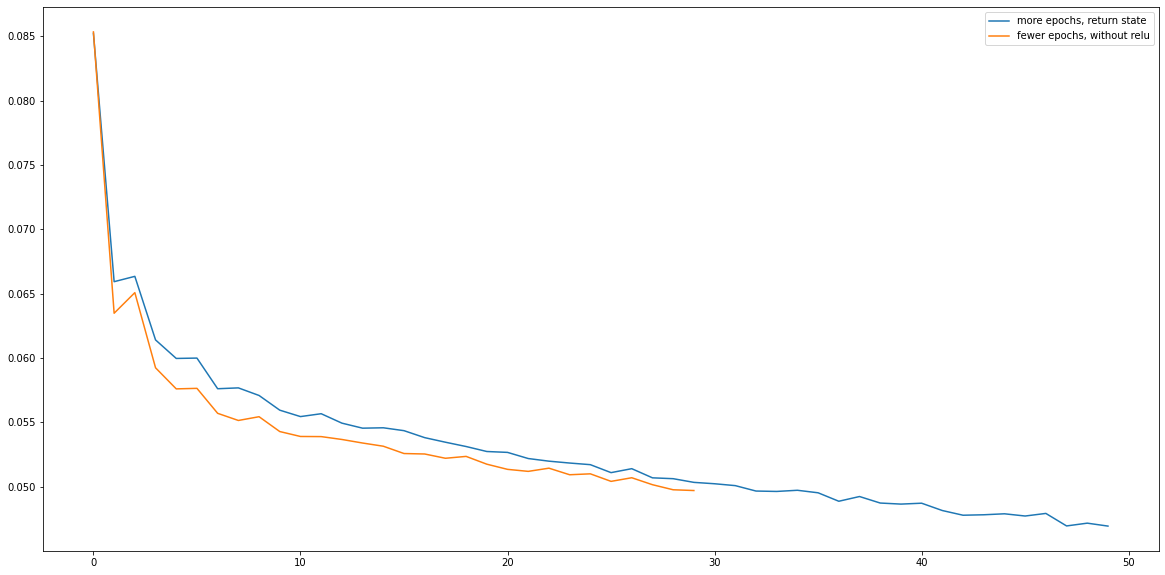

In [117]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(cnn_lstm_history.history['loss'],label = 'more epochs, return state')
ax.plot(cnn_lstm_1_history.history['loss'],label = 'fewer epochs, without relu')
ax.legend()

In [118]:
mae_train_test(cnn_lstm,"CNN-LSTM", X_train_sub,y_train,X_test_sub,y_test,ss1)

Model: CNN-LSTM
----
Train MAE: 28.077274266354568
Test MAE: 0.7197554123666983




In [51]:
mae_train_test(cnn_lstm_1,"CNN-LSTM - No relu", X_train_sub,y_train,X_test_sub,y_test,ss1)

Model: CNN-LSTM - No relu
----
Train MAE: 25.67723097164851
Test MAE: 0.7198006962073465




### Generating forecasts
Since our model is trained on the past 33 months of data, we will feed the same duration of historical data to make our forecasts! 

In [124]:
print(f'test: {df_test.shape}')
print(f'train: {df_train.shape}')

test: (214200, 34)
train: (424124, 34)


In [53]:
## Using only 33 columns to make our next forecasts
df_test_1 = df_test.iloc[:,1:]
ss_test = StandardScaler()
ss_test.fit(df_test_1)
df_test_1_sub = ss_test.transform(df_test_1).reshape((df_test_1.shape[0],subseq,ts,1))

In [54]:
df_test_1.shape

(214200, 33)

In [55]:
print(f'Shape of test: {df_test_1_sub.shape}')

Shape of test: (214200, 1, 33, 1)


In [59]:
# generating forecasts, input = 33 months of data, output = 34th month
preds = cnn_lstm_1.predict(df_test_1_sub)

In [61]:
# since we scaled 33 variables, the standardscaler expects 33 variables so we'll just leave them as 0s
forecasts = np.zeros(shape=(len(preds), 33) )
# replace the first column with the actual preds
forecasts[:,0] = preds[:,0]
# inverse transform and then select the same preds column
forecasts = ss_test.inverse_transform(forecasts)[:,0]

In [73]:
# saving as a new dataframe
submissions = pd.DataFrame({"ID":test.ID, "item_cnt_month":forecasts})
submissions.head()

,ID,item_cnt_month
0,0,0.077
1,1,0.045
2,2,0.108
3,3,0.045
4,4,0.045


In [74]:
# ready for submissions!
submissions.to_csv('../data/submissions.csv',index = False)